# RLLib RecSys Tutorial

This tutorial shows one approach for using *reinforcement learning* with [Ray](https://ray.io/) and [RLlib](https://rllib.io/) to build a *recommender system*.

## Load the training data

The approach given here for building a recommender system could be applied to just about any dataset where *users* are *rating* a set of *items*. It's bounded in terms of memory requirements as the number of users grows, though it would require some re-engineering to handle a very large set of items.

We'll be using the Jester collaborative filtering dataset – which is known for having a high *density*, i.e., where many users have rated many of the items
<https://goldberg.berkeley.edu/jester-data/>

Jester was an online joke recommender hosted a UC Berkeley which collected data from April 1999 through May 2003. See the discussion of "universal queries" in:

> "Eigentaste: A Constant Time Collaborative Filtering Algorithm"  
Ken Goldberg, Theresa Roeder, Dhruv Gupta, Chris Perkins  
*Information Retrieval*, 4(2), 133-151 (July 2001)  
<https://goldberg.berkeley.edu/pubs/eigentaste.pdf>

The data is split into three downloadable files, and the first file contains anonymous ratings from 24,983 users who have rated 36 or more jokes.

Ratings data is organized as a matrix with dimensions `24983 X 101`

  * one row per user
  * first column gives the number of jokes rated by that user
  * the next 100 columns give the ratings for jokes `01` through `100`
  * ratings are real values ranging from `-10.00` to `+10.00`
  * the value `"99"` corresponds to `None` = "not rated"
  
Here's a function to load the dataset:

In [2]:
import csv

NO_RATING = "99"
MAX_RATING = 10.0


def load_data (data_path):
    rows = []

    with open(data_path, newline="") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=",")

        for row in csvreader:
            conv = [None] * (len(row) - 1)

            for i in range(1, len(row)):
                if row[i] != NO_RATING:
                    rating = float(row[i]) / MAX_RATING
                    conv[i - 1] = rating

            rows.append(conv)

    return rows

## Data Discovery

Let's load the dataset into a `pandas` dataframe, then take a look at it:

In [3]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("jester-data-1.csv")
sample = load_data(DATA_PATH)

df = pd.DataFrame(sample)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.782,0.879,-0.966,-0.816,-0.752,-0.850,-0.985,0.417,-0.898,-0.476,...,0.282,NaN,NaN,NaN,NaN,NaN,-0.563,NaN,NaN,NaN
1,0.408,-0.029,0.636,0.437,-0.238,-0.966,-0.073,-0.534,0.888,0.922,...,0.282,-0.495,-0.029,0.786,-0.019,-0.214,0.306,0.034,-0.432,0.107
2,NaN,NaN,NaN,NaN,0.903,0.927,0.903,0.927,NaN,NaN,...,NaN,NaN,NaN,0.908,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.835,NaN,NaN,0.180,0.816,-0.282,0.621,NaN,0.184,...,NaN,NaN,NaN,0.053,NaN,NaN,NaN,NaN,NaN,NaN
4,0.850,0.461,-0.417,-0.539,0.136,0.160,0.704,0.461,-0.044,0.573,...,0.519,0.558,0.427,0.519,0.573,0.155,0.311,0.655,0.180,0.160


Notice above how there are many `NaN` values in the dataset.
Those are *missing values*.
Before we analyze this data any further, we'll need to [*impute*](https://en.wikipedia.org/wiki/Imputation_(statistics)) those missing values.
In other words, substitute each missing value with some appropriate estimate, such as a column mean.
The `SimpleImputer` class in `scikit-learn` provides a good way to handle that
<https://scikit-learn.org/stable/modules/impute.html>

We'll save the imputed sample data in the `X` matrix:

In [4]:
import numpy as np
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(df.values)

X = imp.transform(df.values).T

print(X)

[[-0.782       0.408       0.09045733 ...  0.09045733  0.09045733
   0.243     ]
 [ 0.879      -0.029       0.02084596 ...  0.02084596  0.02084596
   0.267     ]
 [-0.966       0.636       0.03165743 ...  0.03165743  0.03165743
  -0.398     ]
 ...
 [ 0.07676917  0.034       0.07676917 ...  0.07676917  0.07676917
   0.07676917]
 [-0.00312438 -0.432      -0.00312438 ... -0.00312438 -0.00312438
  -0.00312438]
 [ 0.13547109  0.107       0.13547109 ...  0.13547109  0.13547109
   0.13547109]]


Next, we'll use *K-means clustering* as an unsupervised learning approach to understand more about how the dataset is structured. In other word, re-arrange the dataset into `k` clusters of items, based on how many different users have rated them.

Since `k` is a *hyperparameter* we'll need some way to select an appropriate value for it. One approach that's popular for K-means is to evaluate the *inertia* of decreasing error in the clustering models as `k` grows from zero to some limit.

 * <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html>
 * <https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c>
 
We really don't want to work with more than a few clusters – since many small clusters would lead to less *predictive power* in the recsys. Given that there are 100 items, let's measure inertia up to `k=20` clusters.

In [5]:
from sklearn.cluster import KMeans

distortions = []

for i in range(1, 20):
    km = KMeans(
        n_clusters=i,
        init="random",
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=0
    )

    km.fit(X)
    distortions.append(km.inertia_)

Let's visualize the curve of inertia, using `matplotlib`:

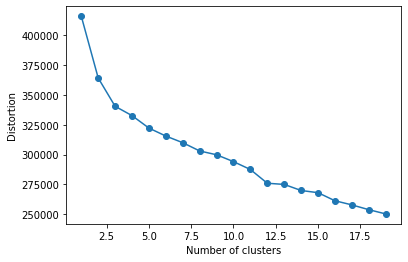

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, 20), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.show()

That plot shows a "knee" in the curve at `k=12` where the decrease in error begins to level out. That's a reasonable number of clusters, such that each cluster will tend to have ~8% of the items. That choice has an inherent trade-off:

  * too few clusters → poor predictions (less accuracy)
  * too many clusters → poor predictive power (less recall)

Now we can run K-means in `scikit-learn` with that hyperparameter `k=12` to get the clusters that we'll use in our RL environment:

In [7]:
K_CLUSTERS = 12

km = KMeans(n_clusters=K_CLUSTERS)
km.fit(X)

y_km = km.fit_predict(X)

From this analysis we'll need the *labels* for each item, i.e., the number of the cluster to which each item gets assigned:

In [8]:
from collections import defaultdict

labels = km.labels_
clusters = defaultdict(set)

for i in range(len(labels)):
    clusters[labels[i]].add(i)

CLUSTERS = dict(clusters)

We'll also use the cluster *centers*, which provide the vector positions (the per-dimension "means") for each cluster.

In [9]:
centers = km.cluster_centers_
CENTERS = centers.tolist()

BTW, let's take a look at the top three clusters from this analysis…

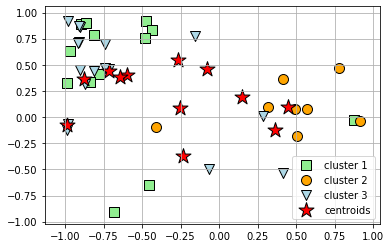

In [10]:
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=100, c="lightgreen",
    marker="s", edgecolor="black",
    label="cluster 1"
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=100, c="orange",
    marker="o", edgecolor="black",
    label="cluster 2"
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=100, c="lightblue",
    marker="v", edgecolor="black",
    label="cluster 3"
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker="*",
    c="red", edgecolor="black",
    label="centroids"
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Not bad. Those clusters show some separation, at least along those three most dominant dimensions.

## A thesis for building an RL recommender system

We're using a thesis here that people tend to like similar "kinds" of items, in this case jokes. While we could go to extra effort to build a classifier model for jokes, it's much simpler to measure ratings for them across a large sample of users likes. In a classic [*collaborative filtering*](https://en.wikipedia.org/wiki/Collaborative_filtering) approach, we could base our recommendations on other users who have similar patterns of rating items. 

On the one hand, that may be expensive to scale as the number of users grows. Instead, an [*item-based collaborative filter*](https://en.wikipedia.org/wiki/Item-item_collaborative_filtering) approach which was invented by [Amazon](https://ieeexplore.ieee.org/document/1167344) for "people who bought x also bought y". This scales to massive datasets by clustering the items based on user ratings.

On the other hand, people change their interests over time but a class CF model doesn't account for that.  For a thorough study of these effects, see ["From Amateurs to Connoisseurs: Modeling the Evolution of User Expertise through Online Reviews"](https://arxiv.org/abs/1303.4402) by Julian McAuley and Jure Leskovec (2013-03-18).

Let's use reinforcement learning to build an item-based recommender system that can "evolve" its recommendations for each individual over time. We'll leverage *exploration* (gather info that lead toward better recommendations in the future) versus *exploitation* (use the best decision given the info so far). So we've clustered the items (jokes) and now we can create a custom environment where:

  * *actions* taken by an agent – recommend items from specific clusters
  * *observation space* – a vector distance from the user's rating history to the cluster centers
  * *rewards* – user ratings for recommended items, with minor penalties for unrated items
  
Each *episode* for an agent will simulate one user's ratings vs. which jokes get recommdened based on our *policy* which is trained using RL.

One other point: a *dense sub-matrix* – in which almost all users have rated the jokes – is defined by the following columns:

In [11]:
DENSE_SUBMATRIX = [ 5, 7, 8, 13, 15, 16, 17, 18, 19, 20 ]

One well-known issue encountered in production use of recommenders is the [*cold start*](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)) problem. When we first begin to make recommendations for a given user, we have zero information about them. So it's not possible to provide personalized recommendations. However, we have the dense sub-matrix above, which almost all users have rated. We can sample from this subset – as "warm" items – to provide to each user at the start of an *episode*. That will give the recommender some initial information to leverage as a starting point.

## A custom Gym environment

Next we'll build a custom environment for training a policy with RLlib.  We'll use OpenAI [Gym](https://gym.openai.com/) as the basis for that. For details about how to build custom Gym environments for working with RLlib, see ["Anatomy of a custom environment for RLlib"](https://medium.com/distributed-computing-with-ray/anatomy-of-a-custom-environment-for-rllib-327157f269e5) and its accompanying source code in the <https://github.com/DerwenAI/gym_example> Git repo.

First, we'll define a few globals… `MAX_STEPS` is the length of an episode, based on how many jokes can be recommended before repeating. Reward values are either the user's rating for the recommended item, or minor penalties for recommending either a "depleted" cluster or an item which the user never rated.

In [12]:
ROW_LENGTH = 100
MAX_STEPS = ROW_LENGTH - len(DENSE_SUBMATRIX)

REWARD_DEPLETED = -0.1	# item recommended from a depleted cluster (no-op)
REWARD_UNRATED = -0.05	# item was never rated by this user

Now for the Gym environment. This is one class and should be defined within one cell – albeit this is a long cell to scroll through…

In [13]:
import gym
from gym import spaces
import random

class JokeRec (gym.Env):
    def __init__ (self, config):
        # NB: here we're passing strings via config; RLlib use of JSON
        # parser was throwing exceptions due to config values
        self.dense = eval(config["dense"])
        self.centers = eval(config["centers"])
        self.clusters = eval(config["clusters"])

        lo = np.array([np.float64(-1.0)] * K_CLUSTERS)
        hi = np.array([np.float64(1.0)] * K_CLUSTERS)

        self.observation_space = spaces.Box(lo, hi, shape=(K_CLUSTERS,), dtype=np.float64)
        self.action_space = spaces.Discrete(K_CLUSTERS)

        # load the dataset
        self.dataset = load_data(config["dataset"])


    def _warm_start (self):
        """
        attempt a warm start, sampling half the dense submatrix of most-rated items
        """
        sample_size = round(len(self.dense) / 2.0)

        for action, items in self.clusters.items():
            for item in random.sample(self.dense, sample_size):
                if item in items:
                    state, reward, done, info = self.step(action)


    def _get_state (self):
        """
        calculate root-mean-square (i.e., normalized vector distance) for the agent's current 
        "distance" measure from each cluster center as the observation
        """
        n = float(len(self.used))

        if n > 0.0:
            state = [ np.sqrt(x / n) for x in self.coords ]
        else:
            state = self.coords

        return state


    def reset (self):
        """
        reset the item recommendation history, select a new user to simulate from among the 
        dataset rows, then run an initial 'warm-start' sequence of steps before handing step
        control back to the agent
        """
        self.count = 0
        self.used = []
        self.depleted = 0
        self.coords = [np.float64(0.0)] * K_CLUSTERS

        # select a random user to simulate
        self.data_row = random.choice(self.dataset)

        # attempt a warm start
        self._warm_start()

        return self._get_state()


    def step (self, action):
        """
        recommend one item, which may result in a no-op -- 
        in production, skip any repeated items per user
        """
        assert action in self.action_space, action
        assert_info = "c[item] {}, rating {}, scaled_diff {}"

        # enumerate items from the cluster selected by the action that haven't been recommended
        # previously to the simulated user
        items = set(self.clusters[action]).difference(set(self.used))

        if len(items) < 1:
            # oops! items from the selected cluster have been depleted, i.e. all have been 
            # recommended previously to the simulated user; hopefully the agent will learn
            # to switch to exploring among the other clusters
            self.depleted += 1
            item = None
            reward = REWARD_DEPLETED
        else:
            # chose an item at random from the selected cluster
            item = random.choice(list(items))
            rating = self.data_row[item]

            if not rating:
                # no-op! this action resulted in an unrated item
                reward = REWARD_UNRATED

            else:
                # success! this action resulted in an item rated by the simulated user
                reward = rating
                self.used.append(item)

                # update the coords history: agent observes its distance to each cluster "evolve"
                for i in range(len(self.coords)):
                    c = self.centers[i]
                    scaled_diff = abs(c[item] - rating) / 2.0
                    self.coords[i] += scaled_diff ** 2.0

        self.count += 1
        done = self.count >= MAX_STEPS
        info = { "item": item, "count": self.count, "depleted": self.depleted }

        return self._get_state(), reward, done, info


    def render (self, mode="human"):
        last_used = self.used[-10:]
        last_used.reverse()
        print(">> used:", last_used)
        print(">> dist:", [round(x, 2) for x in self._get_state()])
        print(">> depl:", self.depleted)

The `JokeRec.step()` method contains the heart of the simulation logic here. It determines the item to be recommend based on the input `action`, then determines the `reward` and the agent's updated vector distance to the cluster centers as the `observation space`.

Overall, this approach is relatively well-behaved and bounded for its memory use as the number of items grows. We're keeping most of the data in memory, but could readily use a distributed key/value store for selecting items, maintaining user history, etc.

## Configuration

Now we'll use the results of K-means clustering on the data sample to prepare a configuration for our custom environment.

We'll use [*proximal policy optimization*](https://docs.ray.io/en/latest/rllib-algorithms.html?highlight=ppo#proximal-policy-optimization-ppo) (PPO) for training a policy in RLlib, taking the default PPO configuration as the foundation here.

In [14]:
import ray
import ray.rllib.agents.ppo as ppo

CONFIG = ppo.DEFAULT_CONFIG.copy()

CONFIG["log_level"] = "WARN"
CONFIG["num_workers"] = 3    # set to `0` for debug

CONFIG["env_config"] = {
    "dataset": DATA_PATH,
    "dense": str(DENSE_SUBMATRIX),
    "clusters": repr(CLUSTERS),
    "centers": repr(CENTERS),
}

Instructions for updating:
non-resource variables are not supported in the long term


Now let's create an instance of our custom Gym environment and call the `reset()` method, which will initialize an episode (simulating one user's ratings), run a "warm start", then return the initial observation:

In [15]:
env = JokeRec(CONFIG["env_config"])
env.reset()

[0.1702998059870974,
 0.13160945569420535,
 0.2681423804511393,
 0.09841656617726818,
 0.15863047902954483,
 0.1002479769758727,
 0.14685495395116913,
 0.21318815046807832,
 0.15619441184731006,
 0.16726457335610548,
 0.18355627504156224,
 0.4404037110335968]

We can randomly select an action, i.e., the label of an item cluster to recommend:

In [16]:
action = env.action_space.sample()
print("action:", action)

action: 2


Let's use that action to take one step:

In [17]:
state, reward, done, info = env.step(action)
print("obs:", state)
print("reward:", reward)

obs: [0.1775311326106294, 0.12503380167978578, 0.2572215434496479, 0.08838209735489139, 0.14682421576899915, 0.122960450751368, 0.1313566138418618, 0.20611732096066065, 0.15985236226718025, 0.18168103918681222, 0.18430292241781163, 0.4237784351983969]
reward: 0.413


We can call the `render()` method to describe more about the agent's state within its environment:

In [18]:
env.render()

>> used: [16, 15, 29, 70, 2]
>> dist: [0.18, 0.13, 0.26, 0.09, 0.15, 0.12, 0.13, 0.21, 0.16, 0.18, 0.18, 0.42]
>> depl: 0


Notice how there are already some other "used" items, due to the warm start.

Next, we'll define a function that runs through one entire episode:

In [19]:
def run_one_episode (env, naive=False, verbose=False):
    """
    step through one episode, using either a naive strategy or random actions
    """
    env.reset()
    sum_reward = 0

    action = None
    avoid_actions = set([])
    depleted = 0

    for i in range(MAX_STEPS):
        if not naive or not action:
            action = env.action_space.sample()

        state, reward, done, info = env.step(action)

        if verbose:
            print("action:", action)
            print("obs:", i, state, reward, done, info)

        # naive strategy: select items from the nearest non-depleted cluster
        if naive:
            if info["depleted"] > depleted:
                depleted = info["depleted"]
                avoid_actions.add(action)

            obs = []

            for a in range(len(state)):
                if a not in avoid_actions:
                    dist = round(state[a], 2)
                    obs.append([dist, a])

            action = min(obs)[1]

        sum_reward += reward

        if done:
            if verbose:
                print("DONE @ step {}".format(i))

            break

    if verbose:
        print("CUMULATIVE REWARD: ", round(sum_reward, 3))

    return sum_reward

Next, another function which uses `run_one_episode()` to measure the baseline performance of a "naïve" strategy, i.e., without use of reinforcement learning to train a policy:

In [20]:
from tqdm import tqdm

def measure_baseline (env, n_iter=1, naive=False, verbose=False):
    history = []

    for episode in tqdm(range(n_iter), ascii=True, desc="measure baseline"):
        sum_reward = run_one_episode(env, naive=naive, verbose=verbose)
        history.append(sum_reward)

    baseline = sum(history) / len(history)
    return baseline

Now let's use this to measure how well our recommender system runs without leveraging RLlib:

In [21]:
baseline = measure_baseline(env, n_iter=1000, naive=True)
print("BASELINE CUMULATIVE REWARD", round(baseline, 3))

measure baseline: 100%|##########| 1000/1000 [00:06<00:00, 149.68it/s]

BASELINE CUMULATIVE REWARD -1.119


## Running Ray and RLlib

At this point we're ready to train a policy with RLlib. First we'll initialize the directory in which to save *checkpoints*, and the directory in which to log results…

In [22]:
import os
import shutil

CHECKPOINT_ROOT = "tmp/rec"
shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

Now start Ray, register our custom environment, and create an agent. BTW, if you see lots of "deprecation" warnings from [Tensorflow](https://www.tensorflow.org/) just ignore those…

In [23]:
from ray.tune.registry import register_env

ray.init(ignore_reinit_error=True)

env_key = "JokeRec-v0"
register_env(env_key, lambda config_env: JokeRec(config_env))
AGENT = ppo.PPOTrainer(CONFIG, env=env_key)

2020-08-29 22:31:31,230	INFO resource_spec.py:231 -- Starting Ray with 3.32 GiB memory available for workers and up to 1.67 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-29 22:31:31,774	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2020-08-29 22:31:33,052	INFO trainer.py:605 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-08-29 22:31:33,054	INFO trainer.py:632 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=72421) WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=72421) Instructions for updating:
(pid=72421) non-resource variables are not supported in the long term
(pid=72419) WARNING:tensorflow:From /

Let's train a policy using the PPO optimizer in RLlib. As the following code steps through each training iteration, watch how the measured improvements in the min, mean, and max rewards per episode.

In [24]:
TRAIN_ITER = 30

df = pd.DataFrame(columns=[ "min_reward", "avg_reward", "max_reward", "steps", "checkpoint"])
status = "reward {:6.2f} {:6.2f} {:6.2f}  len {:4.2f}  saved {}"

for i in range(TRAIN_ITER):
    result = AGENT.train()
    checkpoint_file = AGENT.save(CHECKPOINT_ROOT)

    row = [
        result["episode_reward_min"],
        result["episode_reward_mean"],
        result["episode_reward_max"],
        result["episode_len_mean"],
        checkpoint_file,
        ]

    df.loc[len(df)] = row
    print(status.format(*row))

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
reward -34.60   1.25  18.64  len 84.67  saved tmp/rec/checkpoint_1/checkpoint-1


(pid=72421) WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py:871: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=72421) Instructions for updating:
(pid=72421) Prefer Variable.assign which has equivalent behavior in 2.X.
(pid=72419) WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py:871: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=72419) Instructions for updating:
(pid=72419) Prefer Variable.assign which has equivalent behavior in 2.X.
(pid=72422) WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/ray/rllib/policy/tf_policy.py:871: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=72422) Instructions for updating:
(pid=72422) Prefer Variable.assign which has equivalent behavior in 2.X

reward -41.45   1.54  28.14  len 84.91  saved tmp/rec/checkpoint_2/checkpoint-2
reward -41.45   1.84  28.14  len 85.00  saved tmp/rec/checkpoint_3/checkpoint-3
reward -33.15   2.85  39.00  len 84.92  saved tmp/rec/checkpoint_4/checkpoint-4
reward -30.91   1.92  39.00  len 85.01  saved tmp/rec/checkpoint_5/checkpoint-5
reward -31.20   1.03  32.49  len 84.90  saved tmp/rec/checkpoint_6/checkpoint-6
reward -31.20   2.33  37.83  len 85.02  saved tmp/rec/checkpoint_7/checkpoint-7
reward -21.70   3.35  37.83  len 85.14  saved tmp/rec/checkpoint_8/checkpoint-8
reward -26.33   3.29  32.05  len 85.21  saved tmp/rec/checkpoint_9/checkpoint-9
reward -26.33   4.60  32.05  len 85.23  saved tmp/rec/checkpoint_10/checkpoint-10
reward -17.47   4.61  31.76  len 85.10  saved tmp/rec/checkpoint_11/checkpoint-11
reward -18.32   2.51  26.98  len 85.08  saved tmp/rec/checkpoint_12/checkpoint-12
reward -24.79   3.03  31.57  len 84.89  saved tmp/rec/checkpoint_13/checkpoint-13
reward -24.79   4.44  35.10  len

The learning is stochastic and not guaranteed to improve *monotonically*, i.e., increase the min/mean/max rewards per episode in every training iterations.
We can use a [*pareto archive*](https://ieeexplore.ieee.org/document/781913) to find a *non-dominated* solution.
In other words, among the saved checkpoints of trained policies, which have the best mean rewards per episode, and among those which have the best min and max rewards?
The following code uses the [`paretoset`](https://github.com/tommyod/paretoset) Python implementation to select the best checkpoint:

In [25]:
from paretoset import paretoset

df_front = df.drop(columns=["steps", "checkpoint"])
mask = paretoset(df_front, sense=["max", "max", "max"])

optimal = df_front[mask]
max_val = optimal["avg_reward"].max()

BEST_CHECKPOINT = df.loc[df["avg_reward"] == max_val, "checkpoint"].values[0]
print("best checkpoint:", BEST_CHECKPOINT)

best checkpoint: tmp/rec/checkpoint_28/checkpoint-28


## Rollout to emulate a use case deployment

Now let's define a function to run a *rollout* using a checkpointed policy.
Each rollout iteration will emuluate a deployed use of our recommender system for one user, and we'll measure the average rewards across many iterations:

In [26]:
def run_rollout (agent, env, n_iter=1, verbose=False):
    """
    iterate through `n_iter` episodes in a rollout to emulate deployment in a production use case
    """
    for episode in range(n_iter):
        state = env.reset()
        sum_reward = 0

        for step in range(MAX_STEPS):
            try:
                action = agent.compute_action(state)
                state, reward, done, info = env.step(action)
                sum_reward += reward

                if verbose:
                    print("reward {:6.3f}  sum {:6.3f}".format(reward, sum_reward))
                    env.render()
            except Exception:
                traceback.print_exc()

            if done:
                # report at the end of each episode
                print("CUMULATIVE REWARD:", round(sum_reward, 3), "\n")
                yield sum_reward
                break

Now we can apply the best trained policy in a rollout:

In [27]:
AGENT.restore(BEST_CHECKPOINT)
history = []

for episode_reward in run_rollout(AGENT, env, n_iter=100, verbose=False):
    history.append(episode_reward)
    
print("average reward:", round(sum(history) / len(history), 3))

2020-08-29 22:34:18,313	INFO trainable.py:473 -- Restored on 192.168.1.244 from checkpoint: tmp/rec/checkpoint_28/checkpoint-28
2020-08-29 22:34:18,315	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 28, '_timesteps_total': None, '_time_total': 114.3706648349762, '_episodes_total': 1382}


CUMULATIVE REWARD: 8.439 

CUMULATIVE REWARD: 2.592 

CUMULATIVE REWARD: 4.248 

CUMULATIVE REWARD: 6.659 

CUMULATIVE REWARD: -8.468 

CUMULATIVE REWARD: -4.047 

CUMULATIVE REWARD: 29.742 

CUMULATIVE REWARD: 3.48 

CUMULATIVE REWARD: 20.83 

CUMULATIVE REWARD: -9.888 

CUMULATIVE REWARD: 29.284 

CUMULATIVE REWARD: 6.572 

CUMULATIVE REWARD: -11.485 

CUMULATIVE REWARD: 15.551 

CUMULATIVE REWARD: -0.809 

CUMULATIVE REWARD: 11.055 

CUMULATIVE REWARD: 4.447 

CUMULATIVE REWARD: 7.749 

CUMULATIVE REWARD: -2.91 

CUMULATIVE REWARD: 2.898 

CUMULATIVE REWARD: 15.157 

CUMULATIVE REWARD: 6.053 

CUMULATIVE REWARD: -21.869 

CUMULATIVE REWARD: 6.385 

CUMULATIVE REWARD: -13.157 

CUMULATIVE REWARD: 8.79 

CUMULATIVE REWARD: 9.609 

CUMULATIVE REWARD: 13.713 

CUMULATIVE REWARD: 3.085 

CUMULATIVE REWARD: 20.987 

CUMULATIVE REWARD: 8.156 

CUMULATIVE REWARD: -8.71 

CUMULATIVE REWARD: 3.921 

CUMULATIVE REWARD: -7.116 

CUMULATIVE REWARD: -14.663 

CUMULATIVE REWARD: -12.609 

CUMULATI

How does the reported *average reward* from many rollouts (using RLlib to train a policy) compare with the *baseline cumulative reward* above based on a naïve strategy and no learning?  How does it compare with the predicted *mean reward per episode* from training? 

The baseline reward from a naïve strategy should be much lower (worse user ratings) than the other two measures.

These measures are an estimate for how a user would rate their recommended items.
Of course, not all users will like the jokes, so there will be some rollouts with negative rewards.
Overall we want the average reward to be *positive*, with `MAX_STEPS` as an upper bounds.

## Examine the trained policy

Use the following code to examine the trained policy that was optimized using PPO:

In [28]:
policy = AGENT.get_policy()
model = policy.model

print("\n", model.base_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 12)]         0                                            
__________________________________________________________________________________________________
fc_1 (Dense)                    (None, 256)          3328        observations[0][0]               
__________________________________________________________________________________________________
fc_value_1 (Dense)              (None, 256)          3328        observations[0][0]               
__________________________________________________________________________________________________
fc_2 (Dense)                    (None, 256)          65792       fc_1[0][0]                       
_______________________________________________________________________________________

## Evaluate learning with TensorBoard

You also can run [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize the RL training metrics from the log files:

In [ ]:
!pip install tensorflow
!tensorboard --logdir=$HOME/ray_results

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)


That should output instructions to load a URL similar to `http://localhost:6006/` into your browser.

Finally, let's shutdown Ray gracefully:

In [ ]:
ray.shutdown()